# Buiding Deep Learning Model using Embeddings 

In this notebook we'll build a deep neural network model to answer some questions about embeddings and experiment with a couple variations on the movie rating prediction DNN model we train here.

> **Dataset**: Movielens 20M dataset which has been preprocessed and saved as **ratings.csv** and **movies.csv** are used to build DNN rating prediction model and also to select the best embeddings for our model.

> To check for how the datasets obtained after performing some preprocessing, please look to the notebook 
**Data Preprocessing.ipynb** file. 

> **Aside**: We perform some visualizations on different embeddings configurations for our model and select the best one based on the model's loss.

>**Final**: We also consider using **biases** for our model, whether they affect the model's performance or not.

In this first part, we'll see how to implement a model with embedding layers using the **tf.keras** API. Embeddings are a technique that enable deep neural nets to work with sparse categorical variables.

### Sparse Categorical Variables

By this I mean a categorical variable with lots of possible values(high cardinality), with a small number of them(often just 1) present in any given observation. One good example is words. There are hundreds of thousands of them in the English language, but a single tweet might only have a dozen. Word embeddings are a crucial technique for applying deep learning to natural language. But other examples abound.

I'll be using the **MovieLens** dataset as an example.

user_id: Different users will be having different unique id's with (~140K distinct values).
movie_id: Different movies will be having different unique id's with (~27K distinct values)

An embedding layer would be a good idea for using these variables as inputs to a network.



### MovieLens

The MovieLens dataset consists of ratings assigned to movies by users. Here's a sample:


In [12]:
import os
import random
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

ratings_df = pd.read_csv('ratings.csv')

movies_df = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'year'])

df = ratings_df.merge(movies_df, on = 'movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

df.head()


,userId,movieId,rating,y,movieId_orig,title,year
17081086,123424,167,2.0,-1.52563,167,Free Willy 2: The Adventure Home,1995
11578986,108286,1195,4.0,0.47437,1195,The Godfather: Part II,1974
15951635,109380,3255,5.0,1.47437,3255,Birdy,1984
12481916,64403,2957,5.0,1.47437,2957,Dead Again,1991
15295156,137308,3018,2.5,-1.02563,3018,Awakenings,1990


Ratings range from 0.5 stars to 5. Our goal will be to predict the rating a given user  **ui**  will give a particular movie  **mj** . (The column **y** is just a copy of the rating column with the mean subtracted - this will be useful later.)

userId and movieId are both sparse categorical variables. They have many possible values:



In [16]:
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        df['movieId'].nunique(), df['userId'].nunique(), len(df),
    )
)

138,493 distinct users rated 26,744 different movies (total ratings = 20,000,263)


### Building a rating prediction model in Keras
We want to build a model that takes a user,  **ui**  and a movie, **mj** , and outputs a number from 0.5-5, representing how many stars we think this user would give that movie.

> **Aside**: You may have noticed that the MovieLens dataset includes information about each movie such as its title, its year of release, a set of genres and user-assigned tags. But for now, we're not going to try to exploit any of that extra information.

I see that we need embedding layers to handle these sparse inputs.

Why? Let's look some other alternatives and see why they don't work.

### Bad idea #1: Use user ids and movie ids as numerical inputs
Why not feed in user ids and movie ids as inputs, then add on some dense layers? i.e.:

In [18]:
model = keras.Sequential([
    # 2 input values: user id and movie id
    keras.layers.Dense(256, input_dim=2, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    # A single output node, containing the predicted rating
    keras.layers.Dense(1)
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


In the simplest terms, neural nets work by doing math on their inputs. But the actual numerical values of the ids assigned to users and movies are meaningless. Example **Schindler's List** has id 527 and **The Usual Suspects** has id 50, but that doesn't mean Schindler's List is 'ten times bigger' than The Usual Suspects.

### Bad idea #2: One-hot encoded user and movie inputs
We all are little or more familiar with one-hot encoding, on Categorical Data.

In many problems, we claim that one-hot encoding is "The Standard Approach for Categorical Data". But why is it a bad idea here? Let's see what a model would look like that took one-hot encoded users and movies.

In [19]:
input_size = df['movieId'].nunique() + df['userId'].nunique()

print("Input size = {:,} ({:,} movies + {:,} users)".format(
    input_size, df['movieId'].nunique(), df['userId'].nunique(),
))
model = keras.Sequential([
    # One hidden layer with 128 units
    keras.layers.Dense(128, input_dim=input_size, activation='relu'),
    # A single output node, containing the predicted rating
    keras.layers.Dense(1)
])
model.summary()

Input size = 165,237 (26,744 movies + 138,493 users)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               21150464  
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 21,150,593
Trainable params: 21,150,593
Non-trainable params: 0
_________________________________________________________________


A basic issue here is scaling and efficiency. A single input to our model is a vector of 165,237 numbers (of which we know that 165,235 will be zeros). The feature data for our whole dataset of 20 million rating instances will require a 2-d array of size 20,000,000 x 165,237, or about 3 trillion numbers. 

Also, doing training and inference on our model will be inefficient. To calculate the activations of our first hidden layer, we'll need to multiply our 165k inputs through about 21 million weights - but the vast, vast majority of those products will just be zero.

One-hot encoding is fine for categorical variables with a small number of possible values, like {Red, Yellow, Green}, or {Monday, Tuesday, Wednesday, Friday, Saturday, Sunday}. But it's not so great in cases like our movie recommendation problem, where variables have tens or hundreds of thousands of possible values.

### Good idea: Embedding layers
In short, an embedding layer maps each element in a set of discrete things (like words, users, or movies) to a dense vector of real numbers (its embedding).

>*Aside*: A key implementation detail is that embedding layers take as input the index of the entity being embedded (i.e. we can give it our userIds and movieIds as input). You can think of it as a sort of 'lookup table'. This is much more efficient than taking a one-hot vector and doing a huge matrix multiplication!

As an example, if we learn embeddings of size 8 for movies, the embedding for Legally Blonde (index=4352) might look like:

[1.624,−0.612,−0.528,−1.073,0.865,−2.302,1.745,−0.761]
 
**Where do these come from?**
We initialize an embedding for each user and movie using random noise, then we train them as part of the process of training the overall rating-prediction model.

**What do they mean?** An object's embedding, if it's any good, should capture some useful latent properties of that object. But the key word here is latent AKA hidden. It's up to the model to discover whatever properties of the entities are useful for the prediction task, and encode them in the embedding space. 

### DNN with Embedding Layers
Model should look something like this:
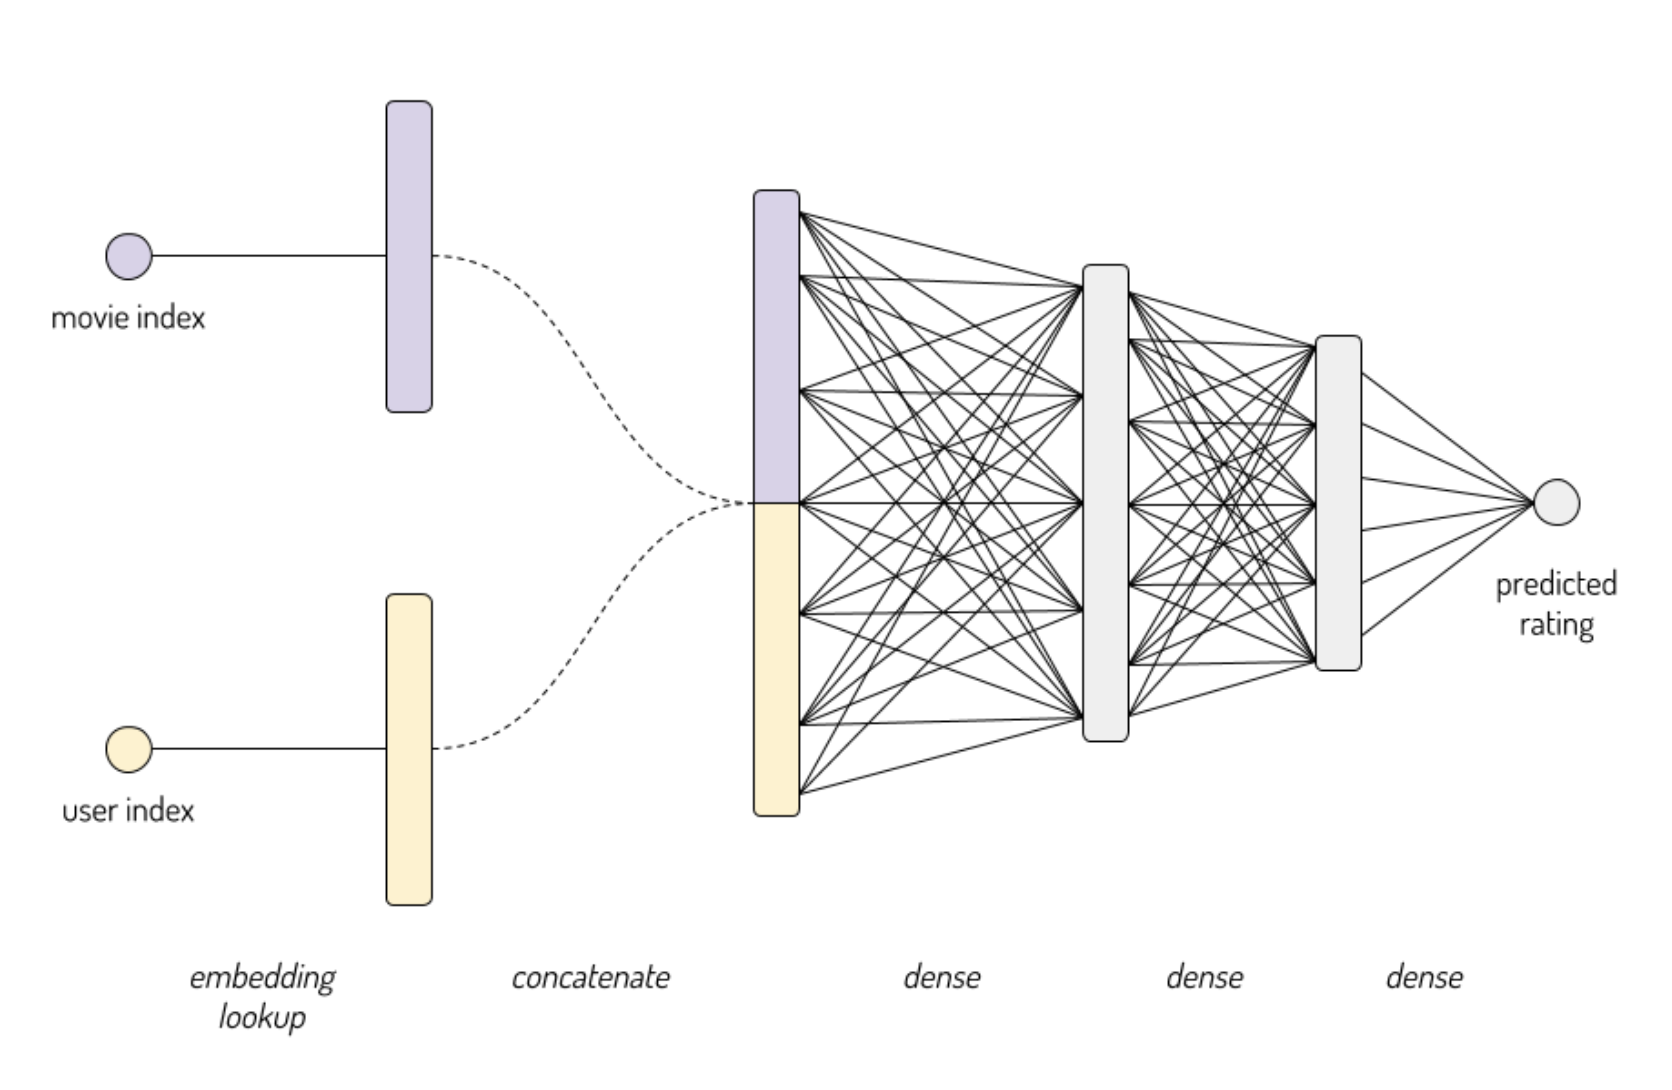

A key thing to note is that this network is not simply a stack of layers from input to output. We're treating the user and the movie as separate inputs, which come together only after each has gone through its own embedding layer.

In [4]:
# Setup code. Make sure you run this first!

# Some predefined hyperparameters. (we might want to change these later for performance comparisions)

LR = .005 # Learning rate
EPOCHS = 20 # Default number of training epochs (i.e. cycles through the training data)
hidden_units = (32,4) # Size of our hidden layers

# We define a function to build and train model which takes different embedding sizes for the input units and epochs as input

def build_and_train_model(movie_embedding_size=8, user_embedding_size=8, verbose=2, epochs=EPOCHS):
    
    tf.set_random_seed(1); np.random.seed(1); random.seed(1) # Set seeds for reproducibility

    # userId and movieId as input units
    user_id_input = keras.Input(shape=(1,), name='user_id')    
    movie_id_input = keras.Input(shape=(1,), name='movie_id')
    
    #Embedding layers for the input units which has to be numerical
    user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                           input_length=1, name='user_embedding')(user_id_input)
    
    movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                            input_length=1, name='movie_embedding')(movie_id_input)
    
    # we concatenate both user and movie embedding layers    
    concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
    
    out = keras.layers.Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

    model = keras.Model(
        inputs = [user_id_input, movie_id_input],
        outputs = out,
    )
    
    print(model.summary())
    
    model.compile(
        tf.train.AdamOptimizer(LR),
        loss='MSE',
        metrics=['MAE'],
    )
    # Training model with input units and target 'y' is considered as it is the 'centered' value of 'rating'(actual target)
    history = model.fit(
        [df.userId, df.movieId],
        df.y,
        batch_size=5 * 10**3,
        epochs=epochs,
        verbose=verbose,
        validation_split=0.15,
    )
    return history


print("Setup complete!")

Setup complete!


In [24]:
# Train three models with different embedding sizes and save the training statistics.
# We'll be using this later in the exercise.

history_8 = build_and_train_model(verbose=0)
history_32 = build_and_train_model(32, 32, verbose=0)
history_64 = build_and_train_model(64, 64, verbose = 0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

## Choosing embedding sizes

when creating our movie and user embedding layers. Run the code cell below to see a visualization of our training and validation error over default 20 epochs of training, again using 8-dimensional, 32-dimensional, 64-dimensional embeddings.

In [8]:
history_FS = (15, 5)
def plot_history(histories, keys=('mean_absolute_error',), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])



At the start of the notebook we also trained a model with 64-dimensional movie and user embeddings. How do you expect the results to compare? Make a prediction, then run the cell below to see.

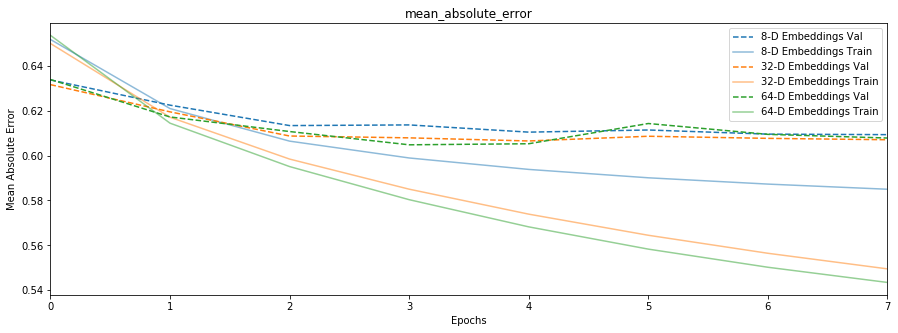

In [7]:
plot_history([ 
    ('8-d embeddings', history_8),
    ('32-d embeddings', history_32),
    ('64-d embeddings', history_64),
])

In the code cell below we try to do some other configurations. So far we've varied movie and user embedding size in lock step, but there's no reason they have to be the same. One or the other can be bigger.

In [9]:
# Example: shrinking movie embeddings and growing user embeddings
history_biguser_smallmovie = build_and_train_model(movie_embedding_size=4, user_embedding_size=16)

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/8
 - 90s - loss: 0.7228 - mean_absolute_error: 0.6522 - val_loss: 0.6880 - val_mean_absolute_error: 0.6352
Epoch 2/8
 - 85s - loss: 0.6677 - mean_absolute_error: 0.6253 - val_loss: 0.6719 - val_mean_absolute_error: 0.6284
Epoch 3/8
 - 86s - loss: 0.6415 - mean_absolute_error: 0.6120 - val_loss: 0.6593 - val_mean_absolute_error: 0.6190
Epoch 4/8
 - 86s - loss: 0.6235 - mean_absolute_error: 0.6028 - val_loss: 0.6550 - val_mean_absolute_error: 0.6191
Epoch 5/8
 - 89s - loss: 0.6112 - mean_absolute_error: 0.5964 - val_loss: 0.6528 - val_mean_absolute_error: 0.6150
Epoch 6/8
 - 88s - loss: 0.6018 - mean_absolute_error: 0.5914 - val_loss: 0.6537 - val_mean_absolute_error: 0.6182
Epoch 7/8
 - 88s - loss: 0.5943 - mean_absolute_error: 0.5874 - val_loss: 0.6526 - val_mean_absolute_error: 0.6164
Epoch 8/8
 - 94s - loss: 0.5880 - mean_absolute_error: 0.5840 - val_loss: 0.6518 - val_mean_absolute_error: 0.6155


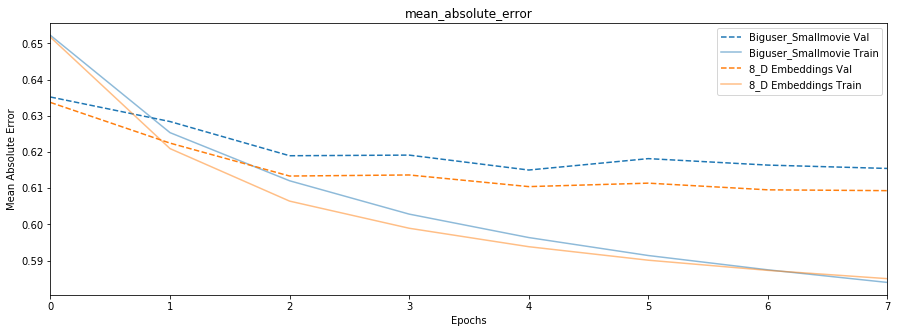

In [10]:
plot_history([('biguser_smallmovie', history_biguser_smallmovie),('8_d embeddings', history_8)])

From all the visualizations above, I see an insight that increasing the size of our embeddings increases our model's capacity. As usual, this comes with the benefit of potentially being able to recognize more complex patterns, increasing our accuracy... and the downside is that our model might use this power to memorize overly-specific patterns that don't generalize well to unseen data. Another downside is training will be a bit slower.

>*In this case, we can see that, with 64-d embeddings,32-d embeddings our validation error goes down a little (if at all) and our training error goes down a lot which means model with 64-d embeddings is 'overfitting.*

>*Also the varied embedding sizes of users and movies with big user and small movie configuration compared to the 8-d embeddings is not performing well and has lot of variation in its training and validation error*. 

**So as a conclusion i consider 8-d embeddings as best fit for the model**



## Adding biases

In this final section, I'd like to implement a modification to model's architecture, by considering **per-movie** biases.

In Machine learning, we all know that a **bias** is just a number that gets added to a node's output value. For each movie, we'll learn a single number that we'll add to the output of what was previously our final node. 



> **1.** One basic observation is that adding biases gives our model more numbers to tune, and in this sense it's strictly increasing its "capacity". This alone is a good enough reason to believe adding biases will at least increase our accuracy on the training set (and possibly on the validation set, depending on how much we're already overfitting).

>**2.** Some movies are, on average, rated significantly higher or lower than others. Per-movie biases are a simple way for our model to account for the relative goodness or badness of movies.

But how is adding biases to our model different from increasing its capacity by making the embedding vectors bigger or adding hidden units? 

> Because our biases get added at the very end, our model has a lot less flexibility in how to use them. And this can be a good thing. At a high level, we're imposing a prior belief - that some movies are intrinsically better or worse than others. This is a form of regularization!


### Coding up biases

Below is the code we used to train our embedding model. Modified it to add per-movie biases.

In [5]:
# 8-d embeddings are selected as best embedding size for the model from above code cells

user_embedding_size = movie_embedding_size = 8

#input units
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

#Embedding layers
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating (before adding bias)
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)


# Adding biases below as "per-movie biases"
bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name = 'bias')(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)

out = keras.layers.Add()([out, movie_bias])

model_bias = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_bias.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)
model_bias.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

### Training

Run the code below to train the model you built in the previous step. 


In [6]:
history_bias = model_bias.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.15,
);

Train on 17000223 samples, validate on 3000040 samples
Epoch 1/20
 - 118s - loss: 0.7279 - mean_absolute_error: 0.6546 - val_loss: 0.6889 - val_mean_absolute_error: 0.6353
Epoch 2/20
 - 122s - loss: 0.6659 - mean_absolute_error: 0.6247 - val_loss: 0.6641 - val_mean_absolute_error: 0.6215
Epoch 3/20
 - 128s - loss: 0.6354 - mean_absolute_error: 0.6096 - val_loss: 0.6511 - val_mean_absolute_error: 0.6155
Epoch 4/20
 - 123s - loss: 0.6173 - mean_absolute_error: 0.6004 - val_loss: 0.6478 - val_mean_absolute_error: 0.6146
Epoch 5/20
 - 124s - loss: 0.6070 - mean_absolute_error: 0.5951 - val_loss: 0.6459 - val_mean_absolute_error: 0.6121
Epoch 6/20
 - 121s - loss: 0.5997 - mean_absolute_error: 0.5913 - val_loss: 0.6479 - val_mean_absolute_error: 0.6106
Epoch 7/20
 - 122s - loss: 0.5942 - mean_absolute_error: 0.5884 - val_loss: 0.6469 - val_mean_absolute_error: 0.6100
Epoch 8/20
 - 123s - loss: 0.5898 - mean_absolute_error: 0.5860 - val_loss: 0.6465 - val_mean_absolute_error: 0.6107
Epoch 9/2

How does it compare to the results we got from the model without biases? Run the code cell below to compare their loss over the course of training.

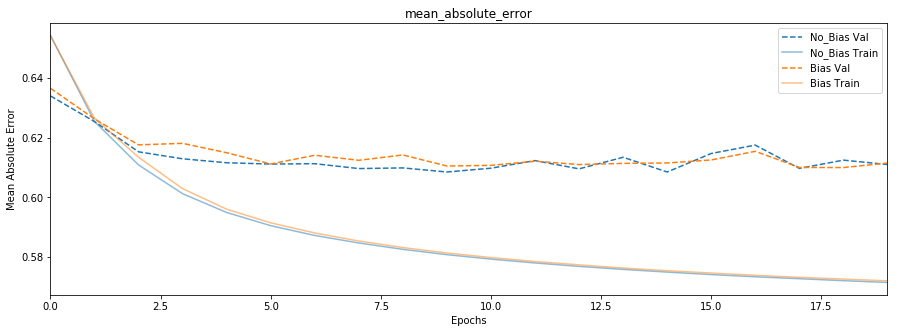

In [25]:
plot_history([ 
    ('no_bias', history_8),
    ('bias', history_bias),
]);

Does adding biases affect our results?

Averaged over many runs, biases seem to help a bit, but there's enough variance between runs (as a result of different random initializations), that you might be seeing better or worse results. If you're seeing a *big* difference (more than, say, +-.02 in the final loss) in either direction, something may have gone wrong.

So biases weren't the huge win we might have hoped for, but it still seems worth testing our hypothesis about how bias values will be distributed among movies.

In [26]:
# Save training history for later comparison

hdf = pd.DataFrame(dict(
    epoch=history_8.epoch,
    val_mae=history_8.history['val_mean_absolute_error'],
    train_mae=history_8.history['mean_absolute_error'],
))
hdf.to_csv('history-8.csv')

In [28]:
# Save training history for later comparison

hdf_bias = pd.DataFrame(dict(
    epoch=history_bias.epoch,
    val_mae=history_bias.history['val_mean_absolute_error'],
    train_mae=history_bias.history['mean_absolute_error'],
))
hdf.to_csv('history-bias.csv')

### Inspecting learned bias values

Let's take a look at the bias values our model has learned. Fill in the missing code in the cell below to load an array of bias values - `b` should be an array with one number for each movie in our training set.

**Hint:** you may want to check out the docs for [`keras.Model.get_layer`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#get_layer). This will be easier if you gave your `Embedding` bias layer a distinctive name in part 2. If you didn't, it may help to look at the output of `model_bias.summary()`.

In [8]:
bias_layer = model_bias.get_layer('bias')

(b,) = bias_layer.get_weights()
print("Loaded biases with shape {}".format(b.shape))

Loaded biases with shape (26744, 1)


Once you've successfully set the value of `bias_layer`, run the cell below which loads a dataframe containing movie metadata and adds the biases found in the previous step as a column.

In [13]:
movies = pd.read_csv('movies.csv', index_col=0, 
                     usecols=['movieId', 'title', 'genres', 'year'])

ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)

# Mapping from original movie ids to canonical ones
mids = movieId_to_canon = df.groupby('movieId')['movieId_orig'].first()
# Add bias column
movies.loc[mids.values, 'bias'] = b
# Add columns for number of ratings and average rating
g = df_train.groupby('movieId_orig')
movies.loc[mids.values, 'n_ratings'] = g.size()
movies.loc[mids.values, 'mean_rating'] = g['rating'].mean()

movies.dropna(inplace=True)

movies.head()

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0.389907,47138.0,3.921051
1,Jumanji,Adventure|Children|Fantasy,1995,-0.100343,21157.0,3.212483
2,Grumpier Old Men,Comedy|Romance,1995,-0.205679,12069.0,3.149764
3,Waiting to Exhale,Comedy|Drama|Romance,1995,-0.718458,2596.0,2.860362
4,Father of the Bride Part II,Comedy,1995,-0.465429,11570.0,3.068237


Which movies have the lowest and highest learned biases? Run the cell below to find out.

In [16]:
from IPython.display import display
n = 5
display(
    "Largest biases...",
    movies.sort_values(by='bias', ascending=False).head(n),
    "Smallest biases...",
    movies.sort_values(by='bias').head(n),
)

'Largest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
25658,Always for Pleasure,(no genres listed),1978,1.809693,1.0,5.0
19857,"Octopus, The (Le poulpe)",Comedy|Crime|Thriller,1998,1.651022,2.0,5.0
25235,No Distance Left to Run,Documentary,2010,1.636505,1.0,5.0
21822,One Small Hitch,Comedy|Romance,2013,1.543762,3.0,4.5
15679,For Neda,Documentary,2010,1.528790,5.0,4.5


'Smallest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
24674,Fugly!,Comedy,2013,-2.895638,1.0,0.5
26673,20 Years After,Drama|Fantasy|Sci-Fi,2008,-2.666615,1.0,0.5
22421,Sand Sharks,Comedy|Horror|Sci-Fi|Thriller,2011,-2.468503,4.0,1.0
15755,Urban Menace,Action|Horror,1999,-2.277655,2.0,0.5
15407,Magic Man,Crime|Mystery|Thriller,2009,-2.131873,3.0,2.0


Run the cell below to generate a scatter plot of movies' average ratings against the biases learned for those movies.

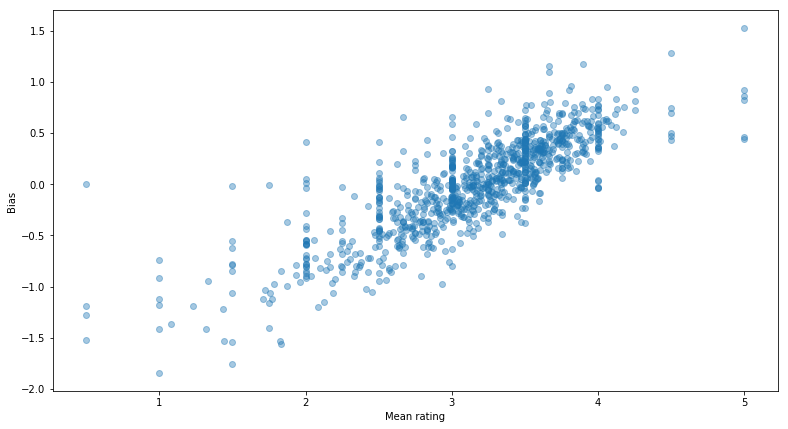

In [15]:
n = 1000
mini = movies.sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.4)
ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias');

Considering this plot and the list of our highest and lowest bias movies, do our model's learned biases agree with what you expected?

Yes, model has learned biases and as expected we could see that model's ratings and bias values are positively proportional to each other. Highest biased movies has highest ratings.